In [43]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading vader_lexicon: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [44]:
df_prices = pd.read_csv('C:\\Users\\User\\Desktop\\NSE-TATAGLOBAL.csv')
print(df_prices.head())
print(df_prices.size)

         Date    Open    High     Low    Last   Close  Total Trade Quantity  \
0  2018-09-28  234.05  235.95  230.20  233.50  233.75               3069914   
1  2018-09-27  234.55  236.80  231.10  233.80  233.25               5082859   
2  2018-09-26  240.00  240.00  232.50  235.00  234.25               2240909   
3  2018-09-25  233.30  236.75  232.00  236.25  236.10               2349368   
4  2018-09-24  233.55  239.20  230.75  234.00  233.30               3423509   

   Turnover (Lacs)  
0          7162.35  
1         11859.95  
2          5248.60  
3          5503.90  
4          7999.55  
16280


In [45]:
#Converting Date column to datetime datatype
df_prices['Date'] = pd.to_datetime(df_prices['Date'])
df_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035 entries, 0 to 2034
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  2035 non-null   datetime64[ns]
 1   Open                  2035 non-null   float64       
 2   High                  2035 non-null   float64       
 3   Low                   2035 non-null   float64       
 4   Last                  2035 non-null   float64       
 5   Close                 2035 non-null   float64       
 6   Total Trade Quantity  2035 non-null   int64         
 7   Turnover (Lacs)       2035 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 127.2 KB


In [46]:
df_prices.dropna(inplace = True)

Text(0, 0.5, 'Open')

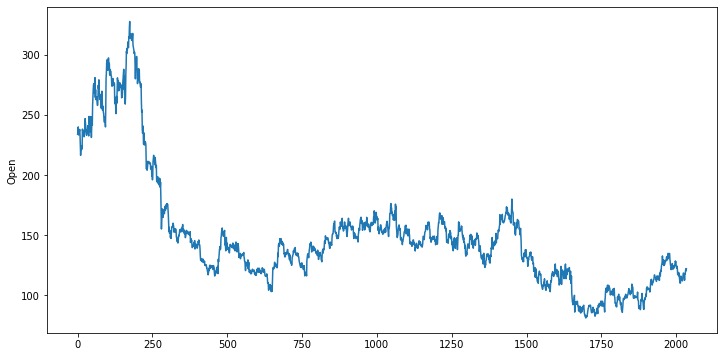

In [47]:
plt.figure(figsize=(12, 6))
df_prices['Open'].plot()
plt.ylabel('Open')

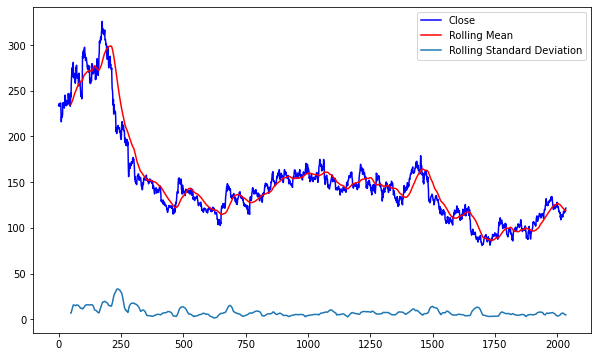

In [48]:
#Plotting moving average
close = df_prices['Close']
ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(10, 6))
df_prices['Close'].plot(color = 'b', label = 'Close')
ma.plot(color = 'r', label = 'Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')
plt.legend()

Text(0.5, 1.0, 'Returns')

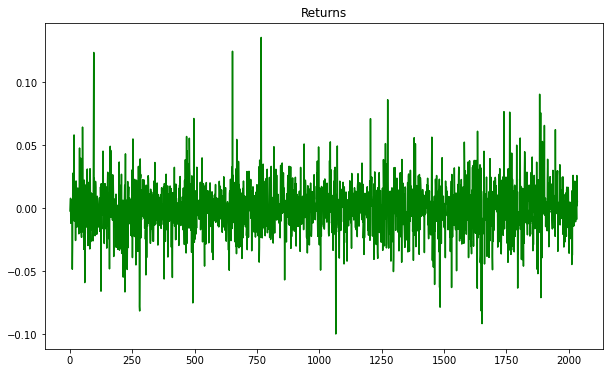

In [49]:
#Plotting returns
returns = close / close.shift(1) - 1

plt.figure(figsize = (10,6))
returns.plot(label='Return', color = 'g')
plt.title("Returns")

In [50]:
train = df_prices[:1000]
test = df_prices[1000:]

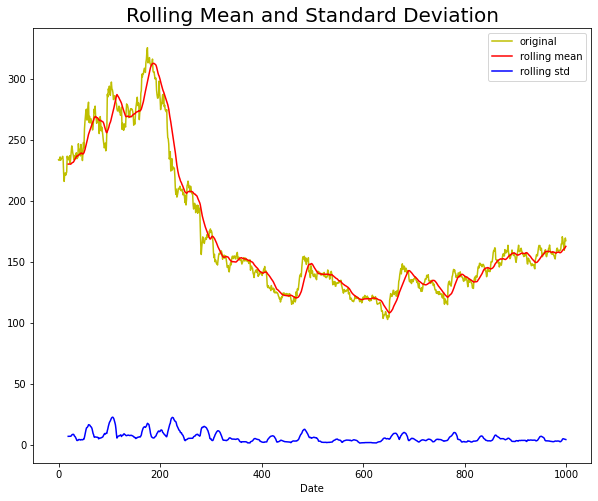

Results of dickey fuller test
ADF Test Statistic : -1.2003051654128856
p-value : 0.6734644237015464
#Lags Used : 16
Number of Observations Used : 983
Weak evidence against null hypothesis, time series is non-stationary 


In [51]:
#Stationarity test
def test_stationarity(timeseries):

 #Determing rolling statistics
 rolmean = timeseries.rolling(20).mean()
 rolstd = timeseries.rolling(20).std()

 #Plot rolling statistics:
 plt.figure(figsize = (10,8))
 plt.plot(timeseries, color = 'y', label = 'original')
 plt.plot(rolmean, color = 'r', label = 'rolling mean')
 plt.plot(rolstd, color = 'b', label = 'rolling std')
 plt.xlabel('Date')
 plt.legend()
 plt.title('Rolling Mean and Standard Deviation',  fontsize = 20)
 plt.show(block = False)
 
 print('Results of dickey fuller test')
 result = adfuller(timeseries, autolag = 'AIC')
 labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
 for value,label in zip(result, labels):
   print(label+' : '+str(value) )
 if result[1] <= 0.05:
   print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
 else:
   print("Weak evidence against null hypothesis, time series is non-stationary ")
test_stationarity(train['Close'])

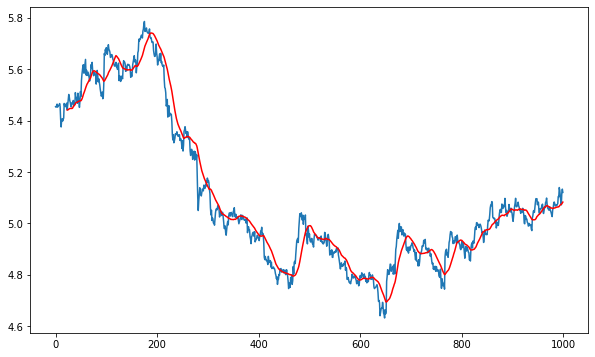

In [52]:
train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean() 
plt.figure(figsize = (10,6))
plt.plot(train_log) 
plt.plot(mav, color = 'red')

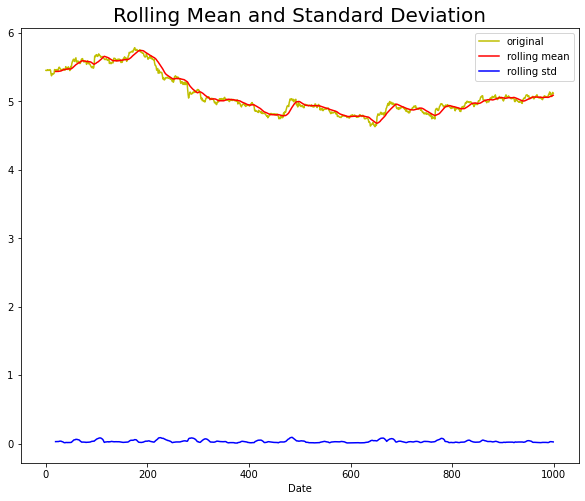

Results of dickey fuller test
ADF Test Statistic : -1.4055896054084958
p-value : 0.5795934771087522
#Lags Used : 0
Number of Observations Used : 999
Weak evidence against null hypothesis, time series is non-stationary 


In [53]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)

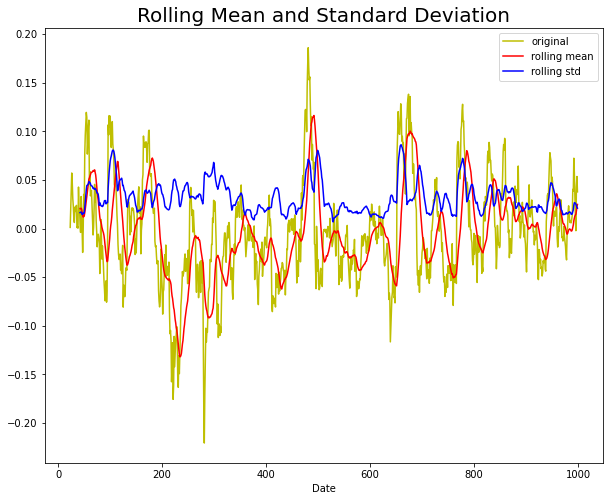

Results of dickey fuller test
ADF Test Statistic : -6.493156762573369
p-value : 1.2124847638863617e-08
#Lags Used : 7
Number of Observations Used : 969
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [54]:
train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)

test_stationarity(train_log_diff)

In [55]:
#Using auto arima to make predictions using log data
from pmdarima import auto_arima
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(n_periods = len(test))
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4984.272, Time=5.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4984.529, Time=0.70 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4982.903, Time=2.32 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4982.912, Time=1.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4986.248, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4986.299, Time=2.35 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4979.081, Time=2.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4983.006, Time=1.98 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4981.058, Time=1.37 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4981.095, Time=0.83 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4987.037, Time=0.59 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4984.620, Time=0.41 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4984.611, Time=0.79 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-4980.783, Time=0.99 sec
 ARIMA(1,1,2)(0,0,0

Text(0, 0.5, 'Actual Stock Price')

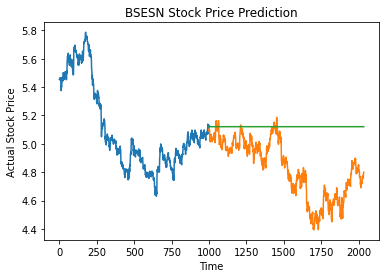

In [56]:
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

In [57]:
#Calculating error
rms = np.sqrt(mean_squared_error(test_log,predictions))
print("RMSE : ", rms)

RMSE :  0.35537945949038957
